In [33]:
from PIL import Image
from scipy import ndimage
from scipy import misc
import numpy as np
import numpy.ma as npma
import scipy as sp
import scipy.spatial.distance as spdist
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
from os import path

#TODO use k-d tree for faster look-up times
'''
loads into a nd-array all images from the given directory

raises exceptions if the path is not a directory or it doesn't exist

dir_path -> path to the directory that contains images

returns -> images
images -> nd-array (numpy) with the images
'''
def load_images (dir_path) :
    p = Path(dir_path)
    
    if not p.exists() :
        raise FileNotFoundError
        
    if not p.is_dir() :
        raise NotADirectoryError
    
    files = [str(x) for x in p.iterdir() if not x.is_dir()]
    
    images = [ndimage.imread(path) for path in files]
    images = np.array(images)
    
    return images

In [3]:
#TODO what do when the source is grayscale and the tiles are RGB
'''
creates an empty mosaic "canvas" on which the tiles will be placed

the dimensions are based on the specified horizontal tile count, the dimensions
of the source image and the tiles

the canvas will be sized so as no tiles are cut off

htcount  -> how many tiles wide should the mosaic be
simg     -> the source image
tshape   -> the dimensions of the tiles (height, width, channels)

returns -> htiles, vtiles, canvas
htiles, vtiles -> the size of the mosaic in number of tiles
canvas         -> the original image resized to the mosaic shape
'''
def mosaic_shape (htcount, simg, tshape) :
    if type(htcount) != int :
        raise TypeError('htcount not an int')
    if htcount < 0 :
        raise ValueError('htcount negative integer')
    if type(tshape) != tuple :
        raise TypeError('tshape not a tuple')
    if type(simg) != np.ndarray :
        raise TypeError('source image not a ndarray')
    
    imheight = simg.shape[0]
    imwidth = simg.shape[1]
    aspect_ratio = imheight / imwidth
    
    theight = tshape[0] 
    twidth = tshape[1]
        
    canvasw = htcount * twidth;
    canvash = aspect_ratio * canvasw
    canvash = round(canvash / theight) * theight # closest multiple of theight
    
    vtcount = canvash / theight
    
    canvas = misc.imresize(simg, (canvash, canvasw))
    
    htiles = htcount
    vtiles = vtcount
    
    return int(htiles), int(vtiles), canvas

672 1000
24 25
28 40


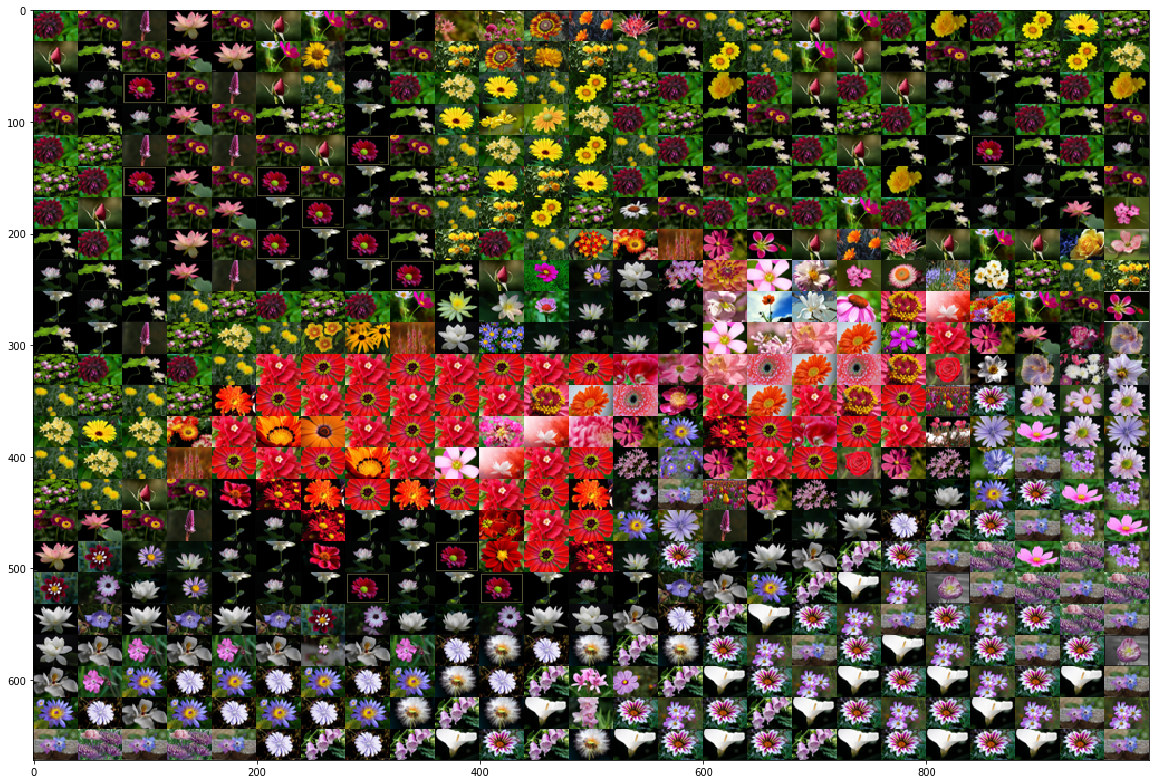

In [112]:
'''
!!!!REDUNDANT!!!!
computes the average color / intensity of the image

image -> source image

returns -> mean
mean -> the average color/intesity (either a tuple of size 3 or a constant)
'''
def immean (image) :
    if type(image) != np.ndarray :
        raise TypeError('image is not ndarray')
    
    rank = len(image.shape)
    
    if rank < 3 :
        mean = np.mean(image)
    else :
        mean = np.mean(image, axis=(0,1))
    
    return mean
'''
returns a /clipshape/ slice of the given image that starts at /start/

image     -> source miage
start     -> point where the clip should begin
clipshape -> dimensions of the clip

returns -> clip
clip -> a /clipshape/ sized slice of the image
'''
def imclip (image, start, clipshape) :
    cliph = clipshape[0]
    clipw = clipshape[1]
    
    b_vslice = start[0]
    e_vslice = b_vslice + cliph
    b_hslice = start[1]
    e_hslice = b_hslice + clipw
    
    vslice = slice(b_vslice, e_vslice)
    hslice = slice(b_hslice, e_hslice)
    
    return image[vslice, hslice]

'''
generates a index matrix for each clip in the image of /imshape/ dimensions

each element of the resulting matrix represents the starting coordinates of the clips

imshape   -> the dimensions of the image (the plane which needs to be clipped)
clipshape -> the dimensions of the clips

returns -> clip_matrix
clip_matrix -> a matrix which contains the coordinates of each clip
'''
def clipindex_mat (imshape, clipshape) :
    imh = imshape[0]
    imw = imshape[1]
    cliph = clipshape[0]
    clipw = clipshape[1]
    
    # create two matrices representing the indices of the clips in the image 
    # the first matrix contains the lines, the second contains the columns
    clip_matrix = np.mgrid[0:imh:cliph, 0:imw:clipw]
    
    # stack those two arrays so that each element represents a coordinate
    clip_matrix = np.stack(clip_matrix, axis=-1)
    
    return clip_matrix


im = ndimage.imread('./data/imaginiTest/ferrari.jpeg')
tile_list = load_images('data/colectie')

# create a data type for storing tuples of (mean_color, image)
immean_dt = np.dtype([('cmean', float, (3,)), ('image', np.uint8, tile_list[0].shape)])
tile_lookup = np.empty(len(tile_list), dtype=immean_dt)
tile_lookup['cmean'] = np.mean(tile_list, (1, 2))
tile_lookup['image'] = tile_list
# tile_lookup = [(immean(tile), tile) for tile in tile_list]
# tile_lookup = np.array(tile_lookup, dtype=immean_dt)

htiles, vtiles, canvas = mosaic_shape(25, im, tile_list[0].shape)

imheight = canvas.shape[0]
imwidth = canvas.shape[1]
clip_width = tile_list[0].shape[1]
clip_height = tile_list[0].shape[0]

print(imheight, imwidth)
print(vtiles, htiles)
print(clip_height, clip_width)


clip_matrix = clipindex_mat(canvas.shape, (clip_height, clip_width))
# we "flatten" the matrix into a (htiles * vtiles, 2) shapped array
clip_matrix = clip_matrix.reshape(np.prod(clip_matrix.shape[0:2]), 2)

tile_cmeans = []

for b_vslice, b_hslice in clip_matrix :
        clip = imclip(canvas, (b_vslice, b_hslice), (clip_height, clip_width))
        
        clip_mean = immean(clip)
        
        tile_cmeans.append(clip_mean)

tile_cmeans = np.array(tile_cmeans)
dist_matrix = spdist.cdist(tile_cmeans, tile_lookup['cmean'])
selected_tiles = np.argmin(dist_matrix, axis=1)

# we ignore the first tile because it doesn't have any top and left neighbours
neighbours = ma.array([0, 0], mask=True)
for i in range(1, selected_tiles.size) :
    if i % htiles != 0 :
        lneighbour = i - 1
        lneighbour = selected_tiles[lneighbour]
        neighbours[0] = lneighbour
    else :
        neighbours[0] = npma.masked
    if i >= htiles :
        tneighbour = int(i / htiles) * htiles - htiles + i % htiles
        tneighbour = selected_tiles[tneighbour]
        neighbours[1] = tneighbour
    
    mtile_cmeans = npma.array(dist_matrix[i], mask=False)
    mtile_cmeans[neighbours[~neighbours.mask]] = npma.masked
    selected_tiles[i] = np.argmin(mtile_cmeans)


    
# paste tiles to canvas
for i in range(selected_tiles.size) :
    b_vslice, b_hslice = clip_matrix[i]
    clip = imclip(canvas, (b_vslice, b_hslice), (clip_height, clip_width))
    
    tile_index = selected_tiles[i]
    tile = tile_lookup[tile_index]['image']
    
    np.copyto(clip, tile)

    

    

            
plt.figure(figsize=(20, 20))
plt.imshow(canvas)
plt.show()

In [110]:
tile_lookup = [(immean(tile), tile) for tile in tile_list]
tile_lookup = np.array(tile_lookup, dtype=immean_dt)
tl = np.empty(500, dtype=immean_dt)
tl['cmean'] = np.mean(tile_list, (1, 2))
tl['image'] = tile_list
print(tl['cmean'])

[[  56.87410714   66.62678571   27.17410714]
 [ 136.03482143  103.01160714  129.56071429]
 [ 118.525       107.06160714   53.14821429]
 ..., 
 [ 149.91339286   83.48660714   93.30535714]
 [  90.51785714   27.99910714   49.12232143]
 [ 187.55714286   65.          157.95892857]]


In [29]:
a =  np.random.randint(0, 255, (10, 2, 3, 2))
b = np.mean(a, axis=(1, 2))
print(np.mean(a[0], axis=(0, 1)))
print(b)

[ 137.33333333  171.66666667]
[[ 137.33333333  171.66666667]
 [  99.16666667  127.83333333]
 [  97.           91.        ]
 [ 141.16666667  125.16666667]
 [ 186.16666667   96.66666667]
 [ 134.66666667   98.16666667]
 [ 172.33333333   85.5       ]
 [  86.66666667   76.66666667]
 [  64.5         101.83333333]
 [ 155.33333333  149.        ]]
